# Fracture density gap filling with direct sampling multiple-point statistics

Prepared for:
Fracture density reconstruction using direct sampling multiple-point statistics and extreme value theory. Applied Computing and Geosciences. Ref.: ACAGS-D-23-00073.

Authors: Tanaka, A.P.B., Renard, P., and Straubhaar, J. (2024)

## Import packages

In [1]:
#Import other packages 
import geone as gn #to use direct sampling
import matplotlib.pyplot as plt
import numpy as np

C:\Users\burgoaa\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading training data set

Loading the synthetic fracture density log derived from one well with and auxiliary variable. The same incomplete image is specified as the training image and as hard data set. In this situation, the image is called a training data set.

In [2]:
#Load data
im = gn.img.readImageGslib('data/syn_well_p10_gap.gslib', missing_value=-9999999) # well log with gap
hard = gn.img.readImageGslib('data/syn_well_p10.gslib')  # only for ploting: hard data to display and compare results

In [3]:
#Find indices of NaN values
nan_indices = np.where(np.isnan(im.val[0]))[0]

#Get the minimum and maximum indices of the missing data
start, end = np.nanmin(nan_indices), np.nanmax(nan_indices)

## Reconstruction of the data with direct sampling
Deesse can be used to reconstruct the missing part of the data set, to simulate the variable in uninformed cells.

### Fill the input structure for deesse and launch deesse

In [4]:
#Direct sampling with Deessee wraper
nreal = 10
deesse_input = gn.deesseinterface.DeesseInput(
    nx=im.nx, ny=im.ny, nz=im.nz,               # set same dimensions grid as for the incomplete image
    nv=2, varname=['P10', 'OC'],                # number of variable(s), name of the variable(s), as for the incomplete image
    nTI=1, TI=im,                               # set the incomplete image as TI
    dataImage=im,                               # set the incomplete image as hard data
    distanceType=['continuous', 'continuous'],  # dystance type: proportion of mismatched node (categorical or continuous)
    nneighboringNode= [30, 1],                  # max. number of neighbors (for the patterns)
    distanceThreshold= [0.05, 0.05],            # acceptation threshold (for distance between patterns)
    maxScanFraction=0.5,                        # max. scanned fraction of the TI (for simulation of each cell)
    seed=444,                                   # seed (initialization of the random number generator)
    nrealization=nreal)                         # number of realization(s)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 11 thread(s)]
DeeSse run complete

Warnings encountered (1 times in all):
#  1: WARNING 00010: a variable in a training image is not exhaustively informed


## Retrieve results and get statistics from the reconstructed data

In [5]:
# Retrieve results
sim = deesse_output['sim']

# Gather all the realizations into one image
all_sim = gn.img.gatherImages(sim)

#Calculate mean and standard deviation
all_sim_mean = gn.img.imageContStat(all_sim, op='mean')
all_sim_std = gn.img.imageContStat(all_sim, op='std')

### Plotting data and simulation results

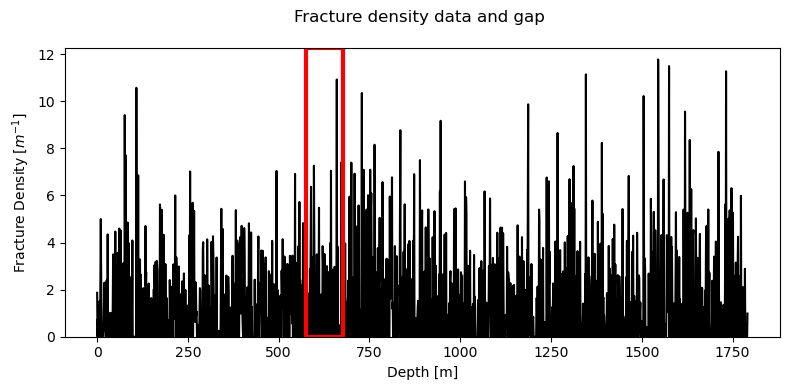

In [6]:
# Display whole well indicating gaps
plt.figure(figsize=(8, 4))

# Plot observed data
plt.plot(hard.val[0, :, 0, 0], 'k')
plt.plot([start, end, end, start, start], [0, 0, np.max(hard.val[0]+0.5), np.max(hard.val[0]+0.5), 0], color='red', linewidth=3)

plt.title('Fracture density data and gap \n')

# Add axis labels
plt.xlabel('Depth [m]')
plt.ylabel('Fracture Density [$m^{-1}$]')

# Set axis limits
plt.ylim(0, np.max(hard.val[0])+0.5)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

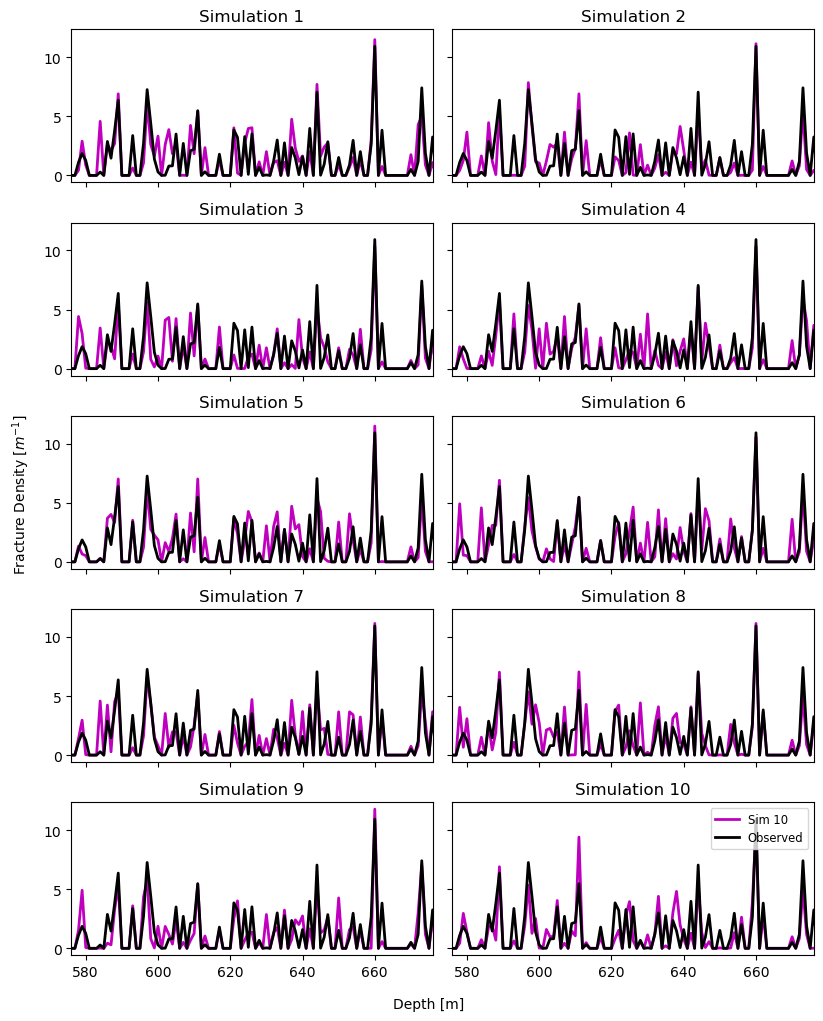

In [7]:
# Display each simulation separately with a zoom at the gap
fig, axs = plt.subplots(int(nreal/2), 2, figsize=(8, 10), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    sim_data = sim[i].val[0, :, 0]
    ax.plot(sim_data, 'm', label=f'Sim {i + 1}', linewidth=2)
    ax.plot(hard.val[0, :, 0, 0], 'k', label='Observed', linewidth=2)
    ax.set_xlim(start, end)  # Zoom at the gap
    ax.set_title(f'Simulation {i + 1}')  # Set the title for each subplot

# Add axis labels
fig.text(0.5, -0.01, 'Depth [m]', ha='center', va='center')
fig.text(-0.01, 0.5, 'Fracture Density [$m^{-1}$]', ha='center', va='center', rotation='vertical')

fig.align_labels()
plt.tight_layout()
plt.legend(loc=1, fontsize='small')

plt.show()